In [5]:
import sys
sys.path.append("../scripts")
from kf import *

In [6]:
def make_ax():
    fig = plt.figure(figsize=(4, 4))
    ax = fig.add_subplot(111)
    ax.set_aspect("equal")
    ax.set_xlim(-5, 5)
    ax.set_ylim(-5, 5)
    ax.set_xlabel("X", fontsize=10)
    ax.set_ylabel("Y", fontsize=10)
    return ax

def draw_trajectory(xs, ax):
    poses = [xs[s] for s in range(len(xs))]
    ax.scatter([e[0] for e in poses], [e[1] for e in poses], s=5, marker=".", color="black")
    ax.plot([e[0] for e in poses], [e[1] for e in poses], linewidth=0.5, color="black")
    
def draw_observations(xs, zlist, ax):
    for s in range(len(xs)):
        if s not in zlist:
            continue
    
        for obs in zlist[s]:
            x, y, theta = xs[s]
            ell, phi = obs[1][0], obs[1][1]
            mx = x + ell*math.cos(theta + phi)
            my = y + ell*math.sin(theta + phi)
            ax.plot([x, mx], [y, my], color="pink", alpha=0.5)
            
def draw_edges(edges, ax):
    for e in edges:
        ax.plot([e.x1[0], e.x2[0]], [e.x1[1], e.x2[1]], color="red", alpha=0.5)
            
def draw(xs, zlist, edges):
    ax = make_ax()
    draw_observations(xs, zlist, ax)
    draw_edges(edges, ax)
    draw_trajectory(xs, ax)
    plt.show()

In [7]:
def read_data():
    hat_xs = {}
    zlist = {}
    
    with open("log.txt") as f:
        for line in f.readlines():
            tmp = line.rstrip().split()
            
            step = int(tmp[1])
            if tmp[0] == "x":
                hat_xs[step] = np.array([float(tmp[2]), float(tmp[3]), float(tmp[4])]).T
            elif tmp[0] == "z":
                if step not in zlist:
                    zlist[step] = []
                zlist[step].append((int(tmp[2]), np.array([float(tmp[3]), float(tmp[4]), float(tmp[4])]).T))
                
        return hat_xs, zlist

In [24]:
class ObsEdge(object):
    def __init__(self, t1, t2, z1, z2, xs, sensor_noise_rate=[0.14, 0.05, 0.05]):
        assert z1[0] == z2[0]
        self.t1, self.t2 = t1, t2
        self.x1, self.x2 = xs[t1], xs[t2]
        self.z1, self.z2 = z1[1], z2[1]
        
        s1 = math.sin(self.x1[2] + self.z1[1])
        c1 = math.cos(self.x1[2] + self.z1[1])
        s2 = math.sin(self.x2[2] + self.z2[1])
        c2 = math.cos(self.x2[2] + self.z2[1])
        
        hat_e = self.x2 - self.x1 + np.array([
            self.z2[0]*c2 - self.z1[0]*c1,
            self.z2[0]*s2 - self.z1[0]*s1,
            self.z2[1] - self.z2[2] - self.z1[1] + self.z1[2]
        ])
        while hat_e[2] >= math.pi:
            hat_e[2] -= math.pi*2
        while hat_e[2] < -math.pi:
            hat_e[2] += math.pi*2
            
        Q1 = np.diag([(self.z1[0]*sensor_noise_rate[0])**2, sensor_noise_rate[1]**2, sensor_noise_rate[2]**2])
        R1 = -np.array([[c1, -self.z1[0]*s1, 0],
                        [s1, self.z1[0]*c1, 0],
                        [0, 1, -1]])
        Q2 = np.diag([(self.z2[0]*sensor_noise_rate[0])**2, sensor_noise_rate[1]**2, sensor_noise_rate[2]**2])
        R2 = np.array([[c2, -self.z2[0]*s2, 0],
                      [s2, self.z2[0]*c2, 0],
                      [0, 1, -1]])
        
        Sigma = R1.dot(Q1).dot(R1.T) + R2.dot(Q2).dot(R2.T)
        self.Omega = np.linalg.inv(Sigma)
        
        print(Sigma)

In [12]:
import itertools
def make_edges(hat_xs, zlist):
    landmark_keys_zlist = {}
    
    for step in zlist:
        for z in zlist[step]:
            landmark_id = z[0]
            if landmark_id not in landmark_keys_zlist:
                landmark_keys_zlist[landmark_id] = []
            
            landmark_keys_zlist[landmark_id].append((step, z))
            
    edges = []
    for landmark_id in landmark_keys_zlist:
        step_pairs = list(itertools.combinations(landmark_keys_zlist[landmark_id], 2))
        edges += [ObsEdge(xz1[0], xz2[0], xz1[1], xz2[1], hat_xs) for xz1, xz2 in step_pairs]

    return edges

[[1.17757304e-01 3.12335106e-04 6.89849398e-05]
 [3.12335106e-04 1.53804544e-02 8.49546610e-03]
 [6.89849398e-05 8.49546610e-03 1.00000000e-02]]
[[0.08806413 0.00103954 0.00025887]
 [0.00103954 0.01202496 0.00653087]
 [0.00025887 0.00653087 0.01      ]]
[[ 0.57053818  0.32987791 -0.01019285]
 [ 0.32987791  0.38066814  0.01706561]
 [-0.01019285  0.01706561  0.01      ]]
[[ 0.33431508  0.19992911 -0.00873365]
 [ 0.19992911  0.26718156  0.01354417]
 [-0.00873365  0.01354417  0.01      ]]
[[ 0.25364782  0.15267083 -0.00821852]
 [ 0.15267083  0.23060273  0.01193168]
 [-0.00821852  0.01193168  0.01      ]]
[[ 0.23788777  0.14083118 -0.00797145]
 [ 0.14083118  0.21656469  0.01159187]
 [-0.00797145  0.01159187  0.01      ]]
[[ 0.16566061  0.09068445 -0.00731743]
 [ 0.09068445  0.17733053  0.00961205]
 [-0.00731743  0.00961205  0.01      ]]
[[ 0.1427196   0.07041497 -0.00682325]
 [ 0.07041497  0.15347076  0.00882968]
 [-0.00682325  0.00882968  0.01      ]]
[[ 0.10475403  0.0310148  -0.00527286]

[[ 0.48370793 -0.22234327 -0.00292351]
 [-0.22234327  0.36244569 -0.01433822]
 [-0.00292351 -0.01433822  0.01      ]]
[[ 0.48304368 -0.22157247 -0.00250332]
 [-0.22157247  0.37681509 -0.01418702]
 [-0.00250332 -0.01418702  0.01      ]]
[[ 0.46556481 -0.24470314 -0.00503715]
 [-0.24470314  0.30394574 -0.01361391]
 [-0.00503715 -0.01361391  0.01      ]]
[[ 0.63438481 -0.23687696 -0.00859955]
 [-0.23687696  0.2013481  -0.01982024]
 [-0.00859955 -0.01982024  0.01      ]]
[[ 0.49263743 -0.17128333 -0.00630619]
 [-0.17128333  0.15301921 -0.01701792]
 [-0.00630619 -0.01701792  0.01      ]]
[[ 0.44641258 -0.16582506 -0.00616315]
 [-0.16582506  0.14631167 -0.01575172]
 [-0.00616315 -0.01575172  0.01      ]]
[[ 0.39636284 -0.16089418 -0.00610096]
 [-0.16089418  0.13961433 -0.01386776]
 [-0.00610096 -0.01386776  0.01      ]]
[[ 0.73564804  0.09526293  0.00338748]
 [ 0.09526293  0.41462799 -0.0210386 ]
 [ 0.00338748 -0.0210386   0.01      ]]
[[ 0.61166758  0.03680898  0.00296437]
 [ 0.03680898  0.

<IPython.core.display.Javascript object>


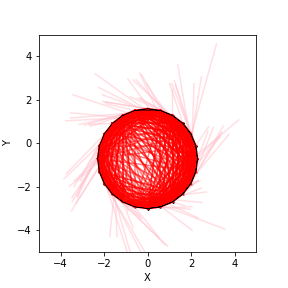

In [25]:
hat_xs, zlist = read_data()
edges = make_edges(hat_xs, zlist)
draw(hat_xs, zlist, edges)